# Market & Credit Risk Demo

This notebook demonstrates a simple **risk analytics workflow**:

- Load ETF price data from Yahoo Finance  
- Compute daily log returns and portfolio returns  
- Calculate 1-day 95% VaR and ES using:
  - Historical simulation  
  - Parametric (variance–covariance) method  
  - Monte Carlo simulation  
- Simulate portfolio credit losses using PD/LGD/EL  
- Plot loss distributions for market and credit risk  

This serves as a compact demonstration of both **market** and **credit** risk analytics for a small portfolio.


In [1]:
import os
import sys

# Ensure repo root is importable when notebook is inside /notebooks
repo_root = os.path.dirname(os.getcwd())
if repo_root not in sys.path:
    sys.path.append(repo_root)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from risk_toolkit.data_loader import load_or_download_prices
from risk_toolkit.returns import compute_log_returns, compute_portfolio_returns
from risk_toolkit.var_es import historical_var_es, parametric_var_es, monte_carlo_var_es
from risk_toolkit.credit_risk import (
    portfolio_expected_loss,
    simulate_credit_losses,
    credit_var_es,
)


## 1. Load ETF Price Data
We will use three ETFs as examples:
- SPY (equities)
- LQD (investment-grade corporate bonds)
- IEF (US Treasuries)


In [2]:
tickers = ["SPY", "LQD", "IEF"]
weights = {"SPY": 0.5, "LQD": 0.3, "IEF": 0.2}

prices = load_or_download_prices(
    tickers,
    start="2023-12-01",
    end="2025-12-01"
)
prices.tail()

/Users/oleksiionishchenko/Documents/ownprojects/sidestuff/Finance_hope/risk_analysis/RiskAnalyticsToolkit/risk_toolkit/data_loader.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(


Ticker,SPY,LQD,IEF
Date,,,
2025-11-21,659.030029,110.510475,96.902924
2025-11-24,668.729980,110.948853,97.052467
2025-11-25,675.020020,111.257706,97.301735
2025-11-26,679.679993,111.636307,97.381500
2025-11-28,683.390015,111.447006,97.212006


## 2. Compute daily log returns and portfolio returns


In [3]:
returns = compute_log_returns(prices)
portfolio_returns = compute_portfolio_returns(returns, weights)

print("Daily return summary:")
display(returns.describe())

print("\nPortfolio daily returns summary:")
display(portfolio_returns.describe())


Daily return summary:


Ticker,SPY,LQD,IEF
count,499.000000,499.000000,499.000000
mean,0.000848,0.000256,0.000213
std,0.010291,0.004448,0.004015
min,-0.060327,-0.019681,-0.013380
25%,-0.003073,-0.002453,-0.002350
50%,0.001151,0.000364,0.000318
75%,0.005756,0.003093,0.002864
max,0.099863,0.016630,0.015371



Portfolio daily returns summary:


count    499.000000
mean       0.000543
std        0.005914
min       -0.029934
25%       -0.002240
50%        0.000832
75%        0.003629
max        0.054271
Name: portfolio, dtype: float64

### 2.1 Price and Return Plots


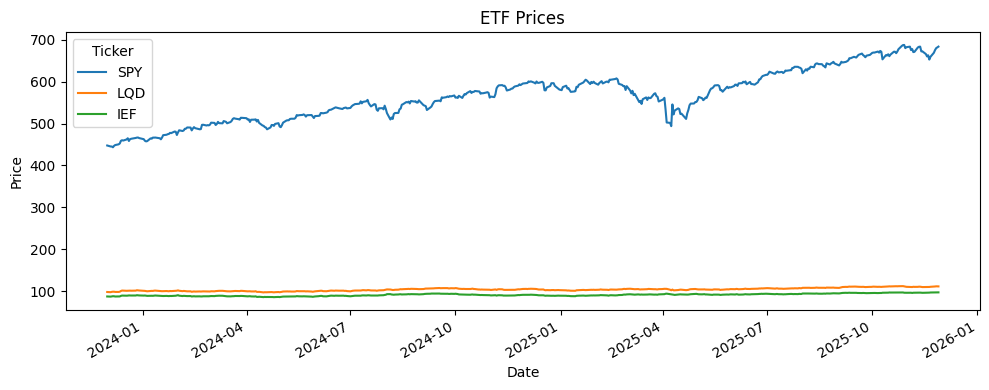

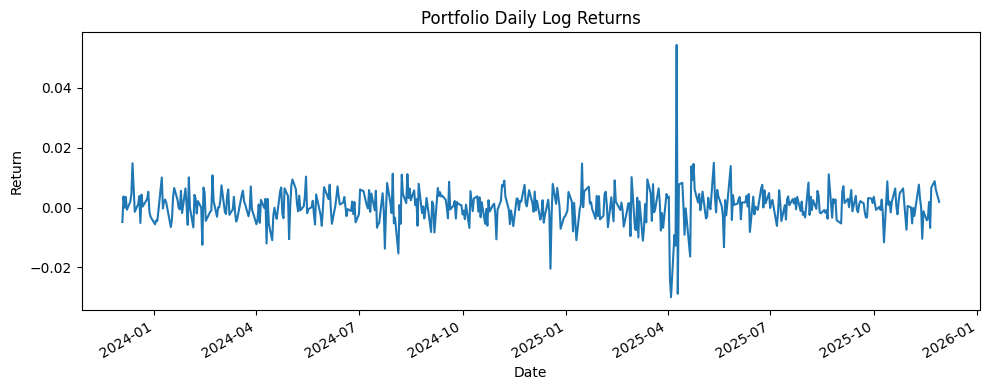

In [4]:
# Price history
plt.figure(figsize=(10, 4))
prices.plot(ax=plt.gca())
plt.title("ETF Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.tight_layout()
plt.show()

# Portfolio returns
plt.figure(figsize=(10, 4))
portfolio_returns.plot(ax=plt.gca())
plt.title("Portfolio Daily Log Returns")
plt.xlabel("Date")
plt.ylabel("Return")
plt.tight_layout()
plt.show()


## 3. Market Risk: VaR and ES (1-day, 95%)


In [5]:
alpha = 0.95

h_var, h_es = historical_var_es(portfolio_returns, alpha=alpha)
p_var, p_es = parametric_var_es(portfolio_returns, alpha=alpha)
m_var, m_es = monte_carlo_var_es(portfolio_returns, alpha=alpha)

print(f"Historical  VaR (95%): {h_var:.4%}, ES: {h_es:.4%}")
print(f"Parametric  VaR (95%): {p_var:.4%}, ES: {p_es:.4%}")
print(f"Monte Carlo VaR (95%): {m_var:.4%}, ES: {m_es:.4%}")


Historical  VaR (95%): 0.8001%, ES: 1.3477%
Parametric  VaR (95%): 0.9184%, ES: 1.1655%
Monte Carlo VaR (95%): 0.9184%, ES: 1.1648%


### 3.1 Loss Distribution and VaR/ES


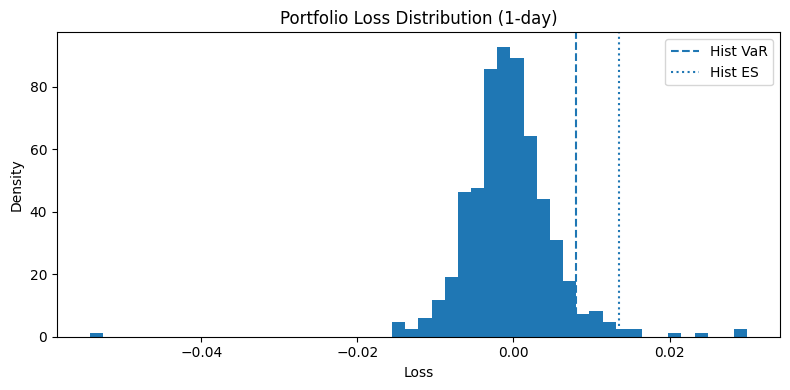

In [6]:
losses = -portfolio_returns.dropna()

plt.figure(figsize=(8, 4))
plt.hist(losses, bins=50, density=True)
plt.axvline(h_var, linestyle="--", label="Hist VaR")
plt.axvline(h_es, linestyle=":", label="Hist ES")
plt.title("Portfolio Loss Distribution (1-day)")
plt.xlabel("Loss")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()


## 4. Credit Risk: PD/LGD/EL and Credit Loss Simulation
We define a small hypothetical portfolio of 3 bonds.


In [10]:
exposures = {
    "Bond_A": 1000000,
    "Bond_B": 750000,
    "Bond_C": 500000,
}

ratings = {
    "Bond_A": "BBB",
    "Bond_B": "BB",
    "Bond_C": "B",
}

el = portfolio_expected_loss(exposures, ratings)
print(f"Portfolio expected credit loss (1Y): {el:,.2f}")


Portfolio expected credit loss (1Y): 37,500.00


### 4.1 Simulated Credit-Loss Distribution and Credit VaR/ES


Credit loss 95% VaR: 300,000.00
Credit loss 95% ES : 385,678.81


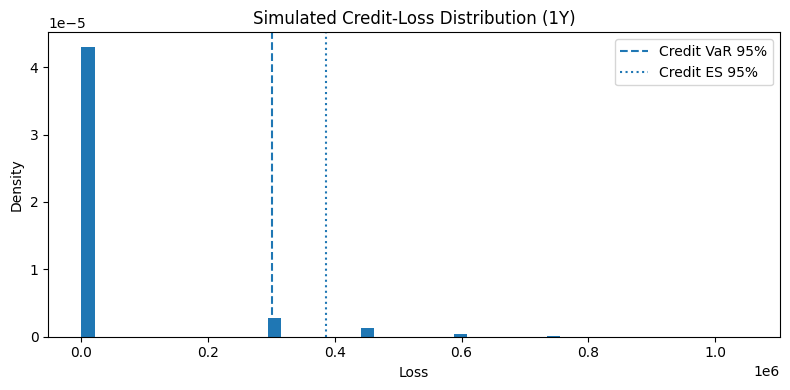

In [11]:
losses_credit = simulate_credit_losses(exposures, ratings, n_sims=50_000)
var95_credit, es95_credit = credit_var_es(losses_credit, alpha=0.95)

print(f"Credit loss 95% VaR: {var95_credit:,.2f}")
print(f"Credit loss 95% ES : {es95_credit:,.2f}")

plt.figure(figsize=(8, 4))
plt.hist(losses_credit, bins=50, density=True)
plt.axvline(var95_credit, linestyle="--", label="Credit VaR 95%")
plt.axvline(es95_credit, linestyle=":", label="Credit ES 95%")
plt.title("Simulated Credit-Loss Distribution (1Y)")
plt.xlabel("Loss")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()


## 5. Summary

- Loaded real ETF price data and computed log returns.  
- Estimated 1-day 95% VaR and ES using historical, parametric, and Monte Carlo methods.  
- Defined a simple bond portfolio with PD/LGD-based credit risk.  
- Simulated credit losses and computed credit VaR and ES.  
- Plotted market loss and credit loss distributions.  

This notebook demonstrates the fundamentals of **market risk** and **credit risk** analytics in one place.
